# Lab 4 - Phys 434
## Andrew Spicciati
## 11/8/21

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd

from ipywidgets import interact

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (10,7)

In [2]:
hf = h5py.File('/home/jovyan/Lab-4-Files/gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [5]:
hf.close()

In [6]:
hf

<Closed HDF5 file>

# Problem 1

## 1) a series of plots to understand the data

In [7]:
#opening the data and putting it into an array
hf = h5py.File('/home/jovyan/Lab-4-Files/gammaray_lab4.h5', 'r')
data = np.transpose(np.array(hf.get('data')))

columns = ['Time','Solar Phase','Longitude','Particle Counts']

df = pd.DataFrame(columns = columns, data = data)

In [8]:
df

,Time,Solar Phase,Longitude,Particle Counts
0,940680016.0,315.000000,45.000000,10.0
1,940680016.1,315.007112,45.006667,8.0
2,940680016.2,315.014225,45.013333,7.0
3,940680016.3,315.021337,45.020000,11.0
4,940680016.4,315.028449,45.026667,8.0
...,...,...,...,...
25919996,943272015.6,345.304884,44.973333,5.0
25919997,943272015.7,345.311996,44.980000,9.0
25919998,943272015.8,345.319109,44.986667,8.0
25919999,943272015.9,345.326221,44.993333,11.0


In [9]:
#showing the range of the particle counts, so I can use this as my number of bins on the y-axis
max(df['Particle Counts']) - min(df['Particle Counts'])

30.0

#### 1.
First, I show the general distribution of Particle Counts. It is clear that this is a Poisson distribution.

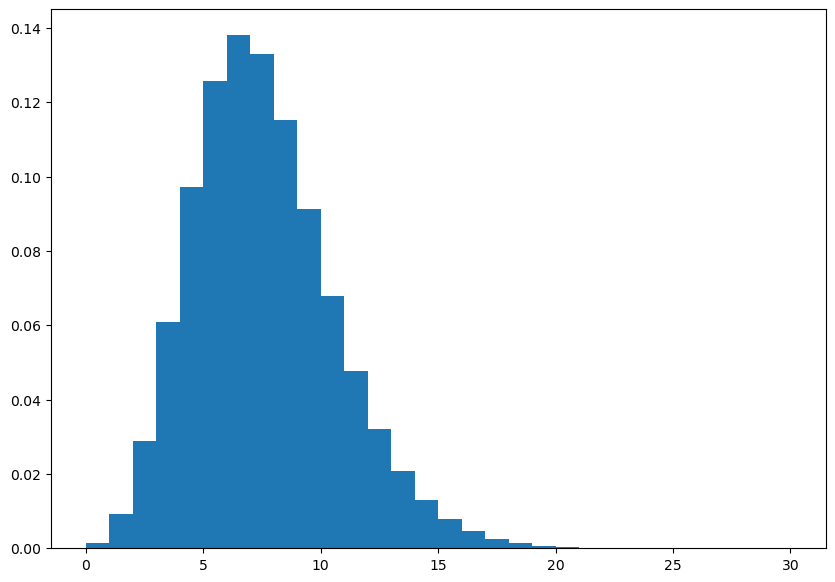

In [10]:
plt.hist(df['Particle Counts'],bins = 30, density=True);

#### 2.
Here is a plot that shows an element of the data that has no signal contamination. As we can see, the distribution of Particle Counts is not dependent of Solar Phase.

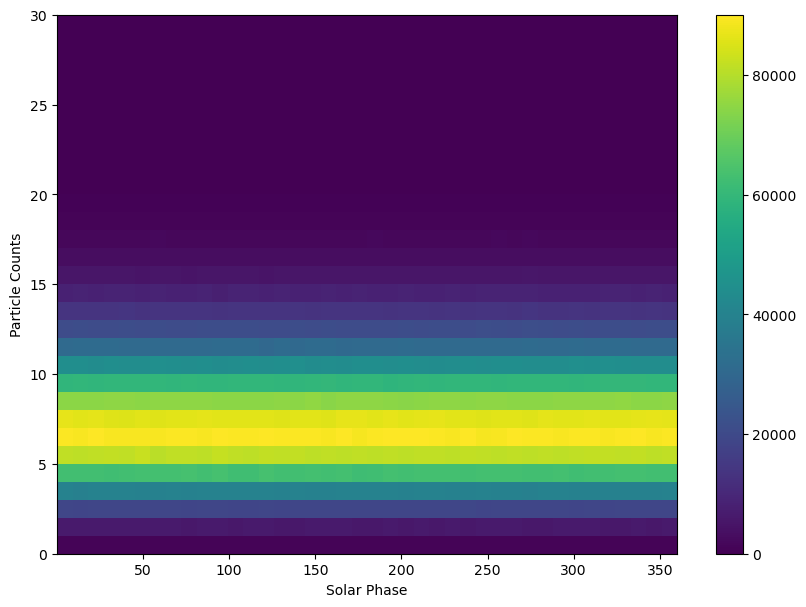

In [11]:
plt.hist2d(df['Solar Phase'],df['Particle Counts'],bins=(40,30))
plt.colorbar()

plt.xlabel('Solar Phase')
plt.ylabel('Particle Counts');

#### 3.
Next, I made some plots with time, and here I do notice a dependance. The period of the dependance is the same as the period of orbit, 5400 seconds.

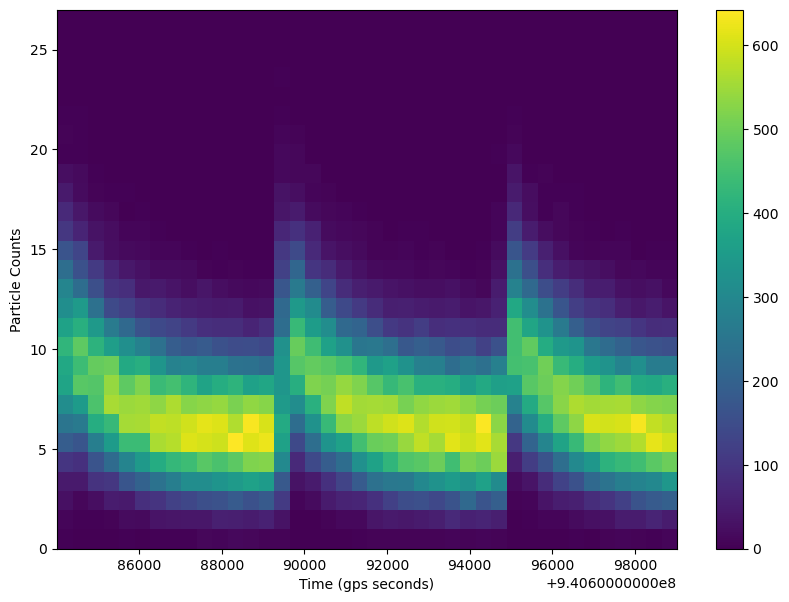

In [12]:
plt.hist2d(df['Time'][40000:190000],df['Particle Counts'][40000:190000],bins=(40,28))
plt.colorbar()

plt.xlabel('Time (gps seconds)')
plt.ylabel('Particle Counts');

#### 4.
By folding the Time axis by the period, I can show the average dependence per period of orbit.

In [13]:
fold = df['Time'] % (90*60)

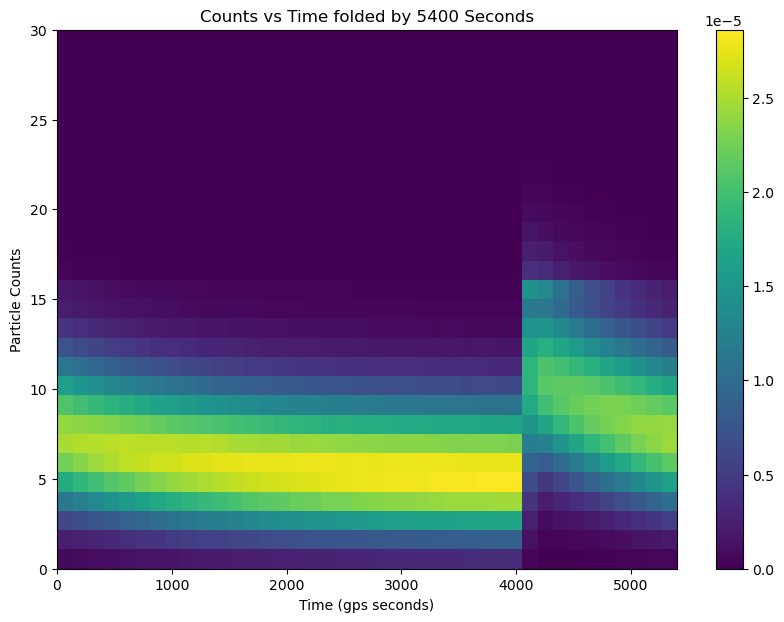

In [14]:
plt.hist2d(fold,df['Particle Counts'],bins=(40,28), density=True)
plt.colorbar()

plt.xlabel('Time (gps seconds)')
plt.ylabel('Particle Counts')
plt.title('Counts vs Time folded by 5400 Seconds');

#### 5.
Next I plot longitude, and notice that it has the same dependence as time. This makes sense because longitude is varying at the same rate as time is. Going forward I decide to work with longitude, because it doesn't require being folded. 

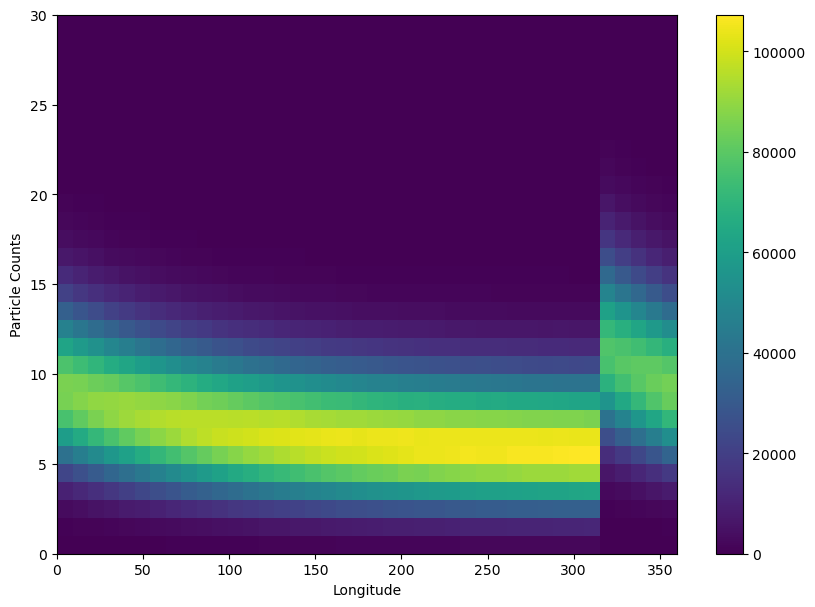

In [15]:
plt.hist2d(df['Longitude'],df['Particle Counts'],bins=(40,30))
plt.colorbar()

plt.xlabel('Longitude')
plt.ylabel('Particle Counts');

#### 6.
I shift the data so it is continuous from 0 to 360.

In [16]:
longitude = (df['Longitude'] + 45) % 360

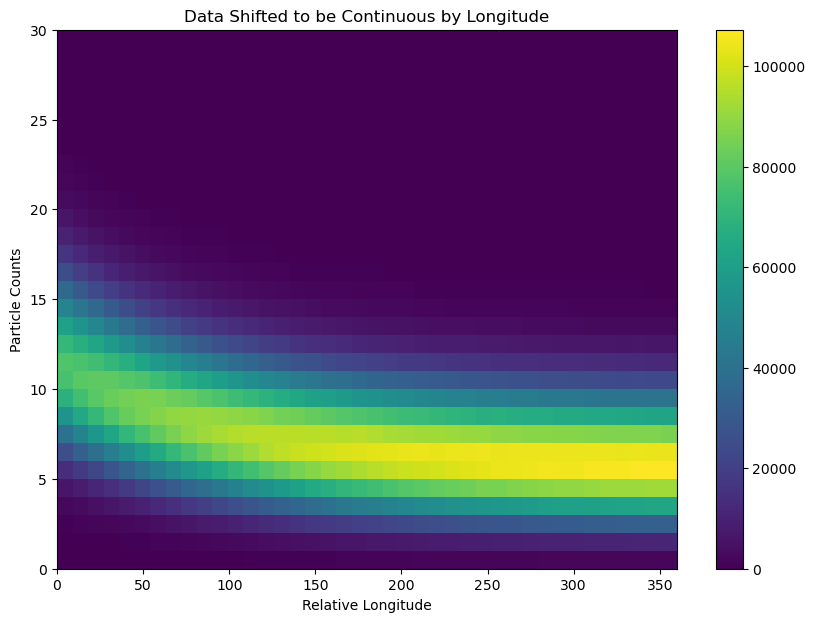

In [17]:
plt.hist2d(longitude,df['Particle Counts'],bins=(40,30));
plt.colorbar()

plt.xlabel('Relative Longitude')
plt.ylabel('Particle Counts')
plt.title('Data Shifted to be Continuous by Longitude');

## 2) Find and describe as accurately as you can how the background changes.

This plot shows how the background changes with longitude, and as I showed earlier, this is directly related to 90 minute orbital periods of the satellite. One thing to note here: The x-axis is wrong, as it actually starts at longitude of 315. With time, the background distribution of particle counts is at its max at longitude of 315 and falls off with what appears to be exponential decay; flattening out around 6 particle counts from 200 to 360 relative degrees.  

## 3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

Since the data is poisson, the time dependance of the data can be approximated by the average. So here I calculate and plot the average of the particle counts by longitude -- shifted by 45 degrees still.

In [18]:
df2 = df.sort_values(by = 'Longitude', ignore_index = True)
df2 

,Time,Solar Phase,Longitude,Particle Counts
0,941008741.0,294.846962,0.000000,4.0
1,941186941.0,8.932378,0.000000,6.0
2,942061741.0,307.169878,0.000000,18.0
3,941165341.0,272.679601,0.000000,7.0
4,942720541.0,2.879601,0.000000,6.0
...,...,...,...,...
25919996,942396540.9,359.080822,359.993333,8.0
25919997,943211940.9,32.623183,359.993333,10.0
25919998,942391140.9,335.017627,359.993333,9.0
25919999,941186940.9,8.925266,359.993333,7.0


In [19]:
#there's gotta be a better way to calculate average, this takes forever

x = np.linspace(0.5,360,720)
avg = []
idx = 0
length = len(df2['Particle Counts'])
for a in x:
    tot = 0
    val = 0
    amt = 0
    while val < a and idx < length:
        val = df2['Longitude'][idx]
        tot += df2['Particle Counts'][idx]
        idx+= 1
        amt += 1
    avg.append(tot/amt)

In [20]:
#some code I wrote a while back to make a running average to smooth plots
def boxcar_avg(data, width=1):

    if width < 1:
        width = 1

    car_width = 1 + 2*width

    running_avg = []
    for i in range(len(data)):

        avg = data[i]
        for a in range(1, width+1, 1):
            if (-1 + width) < i < (len(data) - width):
                avg += data[i+a] + data[i-a]
            else:
                score = i - a
                score2 = i + a

                if score >= 0 and score2 <= (len(data) - 1):
                    avg += data[i+a] + data[i-a]
                elif score >= 0:
                    avg += data[i-a]
                elif score2 <= (len(data)-1):
                    avg += data[i+a]
        running_avg.append(avg)
    running_avg2 = []
    for a in running_avg:
        running_avg2.append(a/car_width)
    return running_avg2

In [21]:
idx_jump = np.argwhere(np.where(x>314,x,np.inf)<315)[0][0]
new_avg = avg[idx_jump:] + avg[:idx_jump]

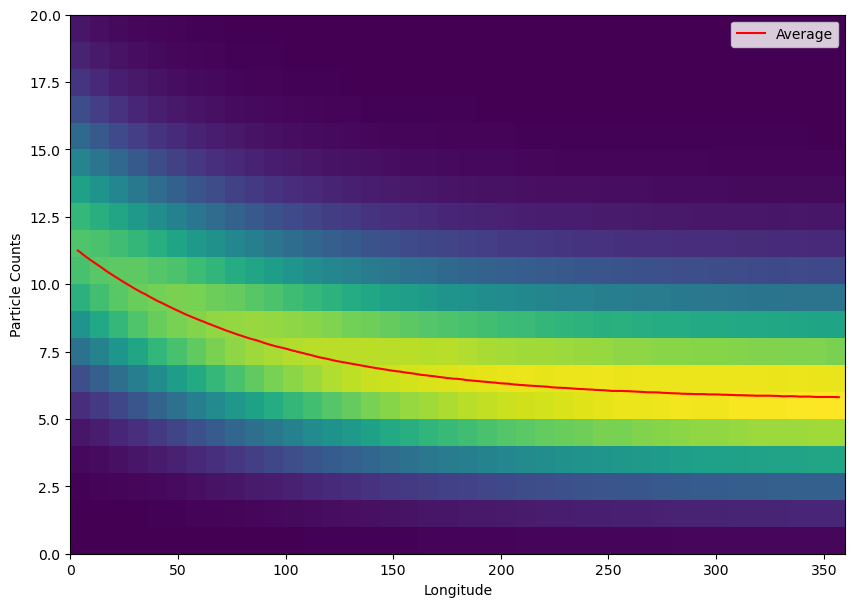

In [22]:
longitude = (df2['Longitude'] + 45) % 360
plt.plot(x[6:-6],boxcar_avg(new_avg,4)[6:-6],color='r', label = 'Average')
plt.hist2d(longitude,df2['Particle Counts'],bins=(40,30),label='Data')
plt.ylim(0,20)
plt.xlabel('Longitude')
plt.ylabel('Particle Counts')
plt.legend();

Here, I tried to fit an expontial with the average. Because we haven't learned how to do this, I had to guess and check all the parameters by hand:

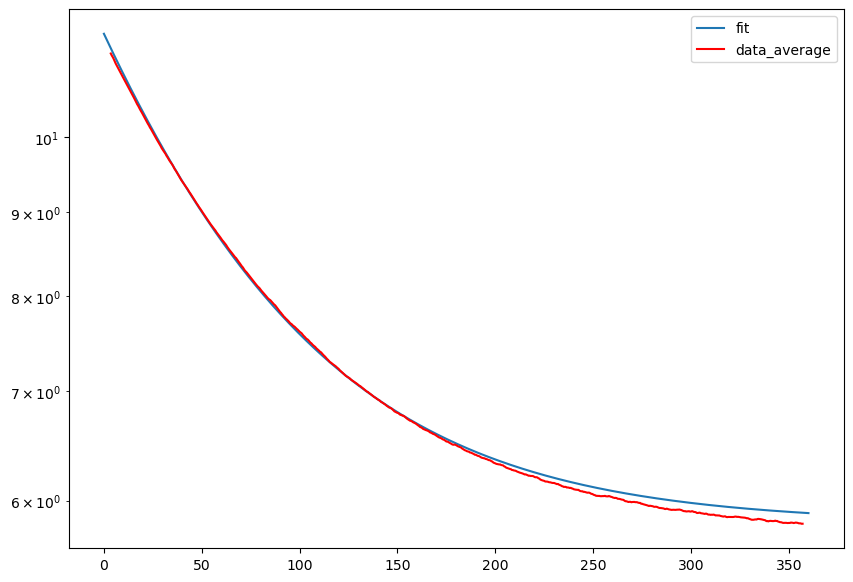

In [23]:
t = np.linspace(0,360,3600)
exp = new_avg[2]*(1/(1.98*np.exp(t/84.8))) + new_avg[-5]

plt.plot(t,exp, label = 'fit')

plt.plot(x[6:-6],boxcar_avg(new_avg,4)[6:-6],color='r', label = 'data_average')

plt.yscale('log')
plt.legend();

This model seems to be a decent fit to my data, only varying noticably from 200 to 360 degrees longitude. I'm sure a better fit is possible, but I did my best with the tools I know.

## 4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

In [24]:
def calc_five_sigma(avg):
    return stats.poisson.ppf(stats.norm.cdf(5),mu=avg)
    

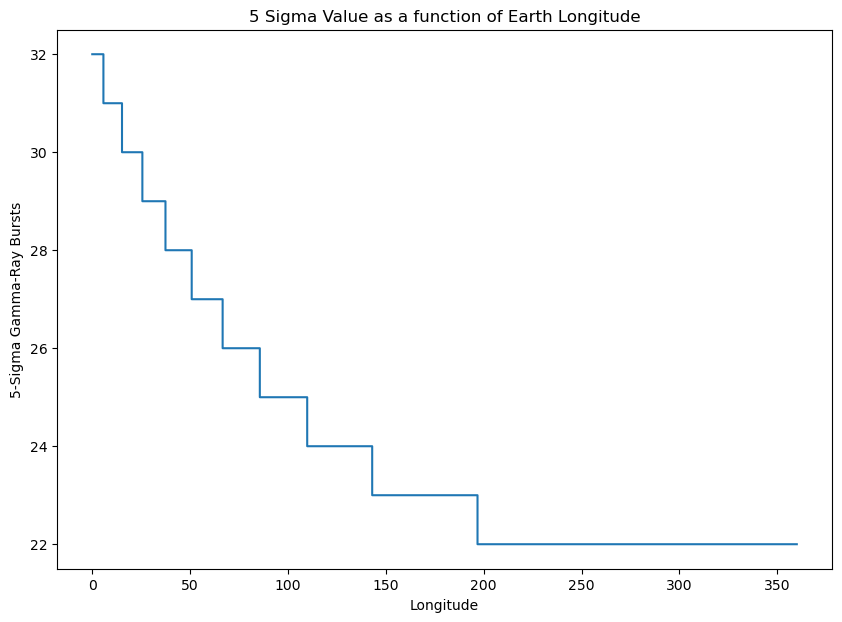

In [25]:
plt.step(t,calc_five_sigma(exp))
plt.xlabel('Longitude')
plt.ylabel('5-Sigma Gamma-Ray Bursts')
plt.title('5 Sigma Value as a function of Earth Longitude');

For this, I plotted the 5-Sigma value as a function of time using my exponential fit. This is a discrete plot due to the values of the poisson distribution being discrete.

# Problem 2

## 1) Dowload the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

In [26]:
hf = h5py.File('/home/jovyan/Lab-4-Files/images_lab4.h5', 'r')

In [27]:
hf.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [28]:
hf

<HDF5 file "images_lab4.h5" (mode r)>

In [29]:
image1 = np.array(hf.get('image1'))

In [30]:
imgstack = np.transpose(np.array(hf.get('imagestack')))

In [31]:
imgstack.shape

(10, 200, 200)

In [32]:
imgstack[0].shape

(200, 200)

In [33]:
sum(imgstack[0].flatten())

1208.7426630496484

# 2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

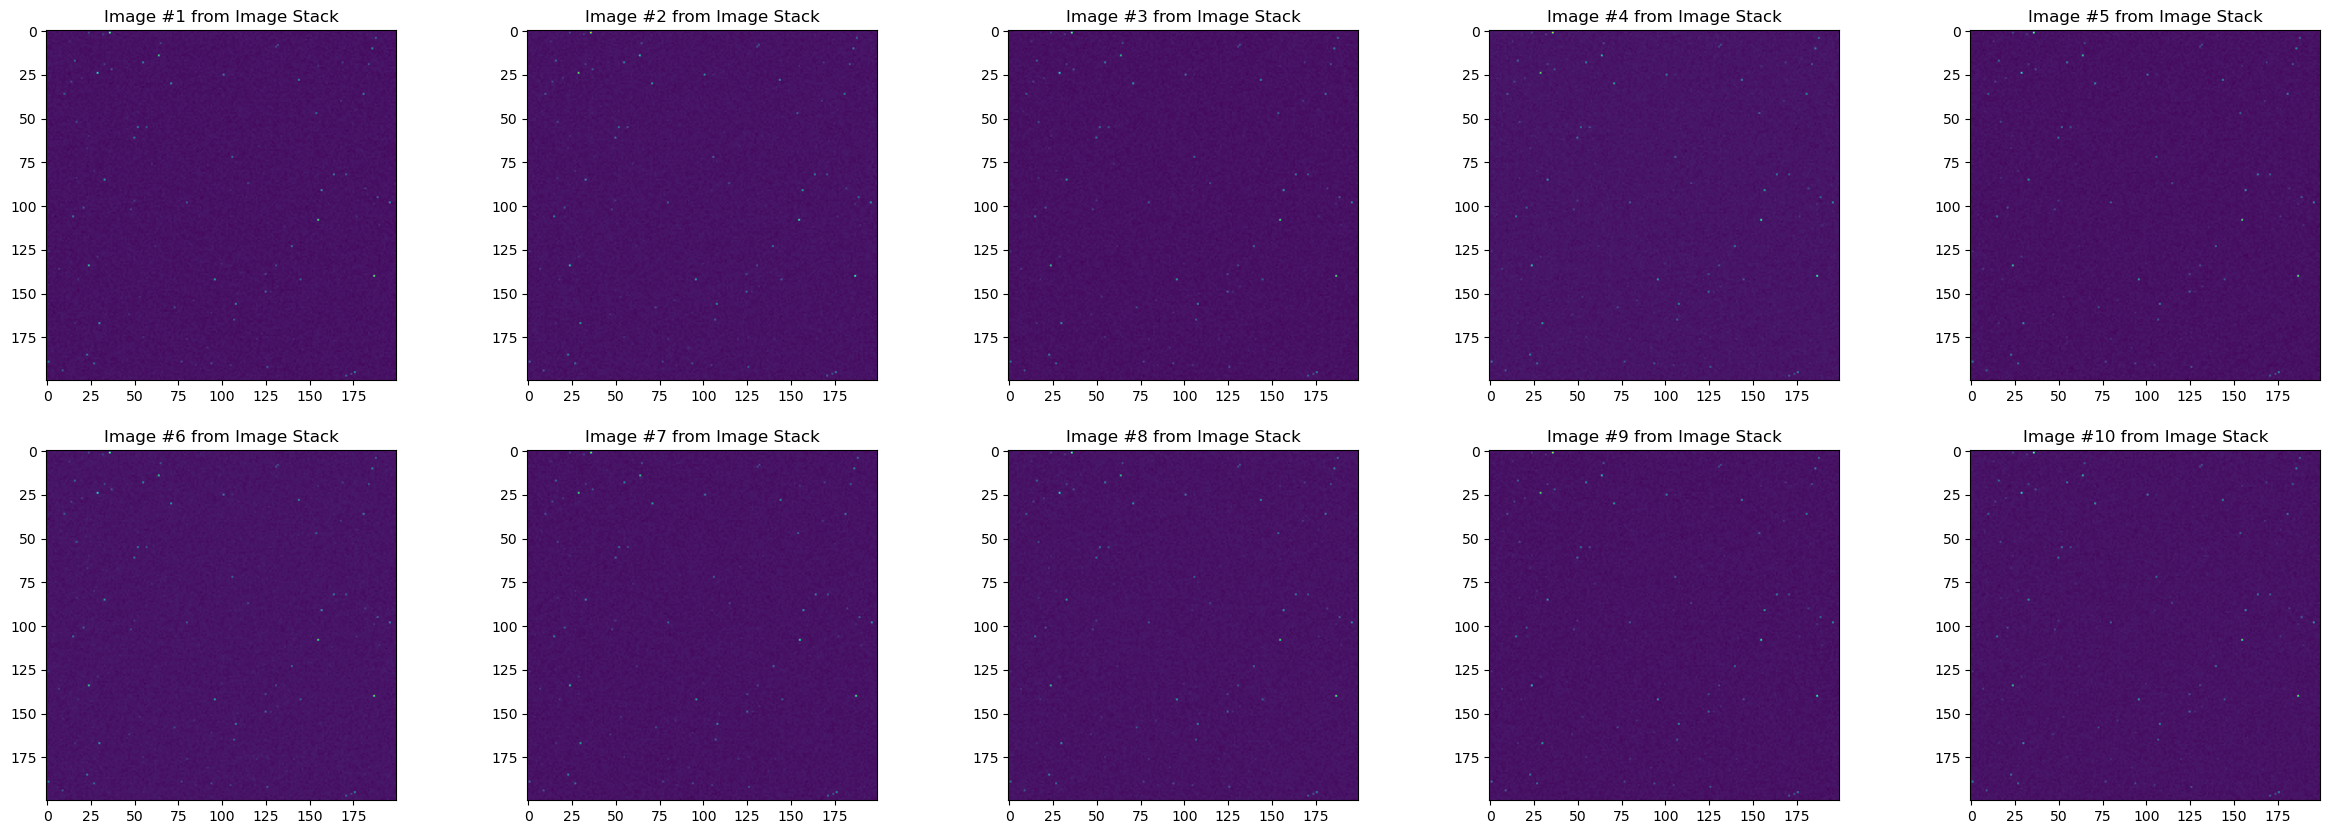

In [34]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(2, 5)
for i in range(2):
    for a in range(5):
        ax[i][a].imshow(imgstack[a+(5*i)])
        ax[i][a].set_title(f'Image #{a+(5*i)+1} from Image Stack')

There does not appear to be any signal contamination (no streaks or patterns in the images). Additionally, the stars are consistent in the images -- they do not appear to rotate or shift, so we can say they are consistent spatially.

---

To see if the background is time dependent, I first need to look for the background PDF. To do so, I first take a look at all of the pixel intensity values as a whole -- to see what the full distribution of all 10 images is. 

In [35]:
def get_counts(image):
    pixel_vals = []
    for i in range(len(image[0])):
        for a in range(len(image[1])):
            pixel_vals.append(image[i][a])
    return pixel_vals

In [36]:
b = imgstack.flatten()

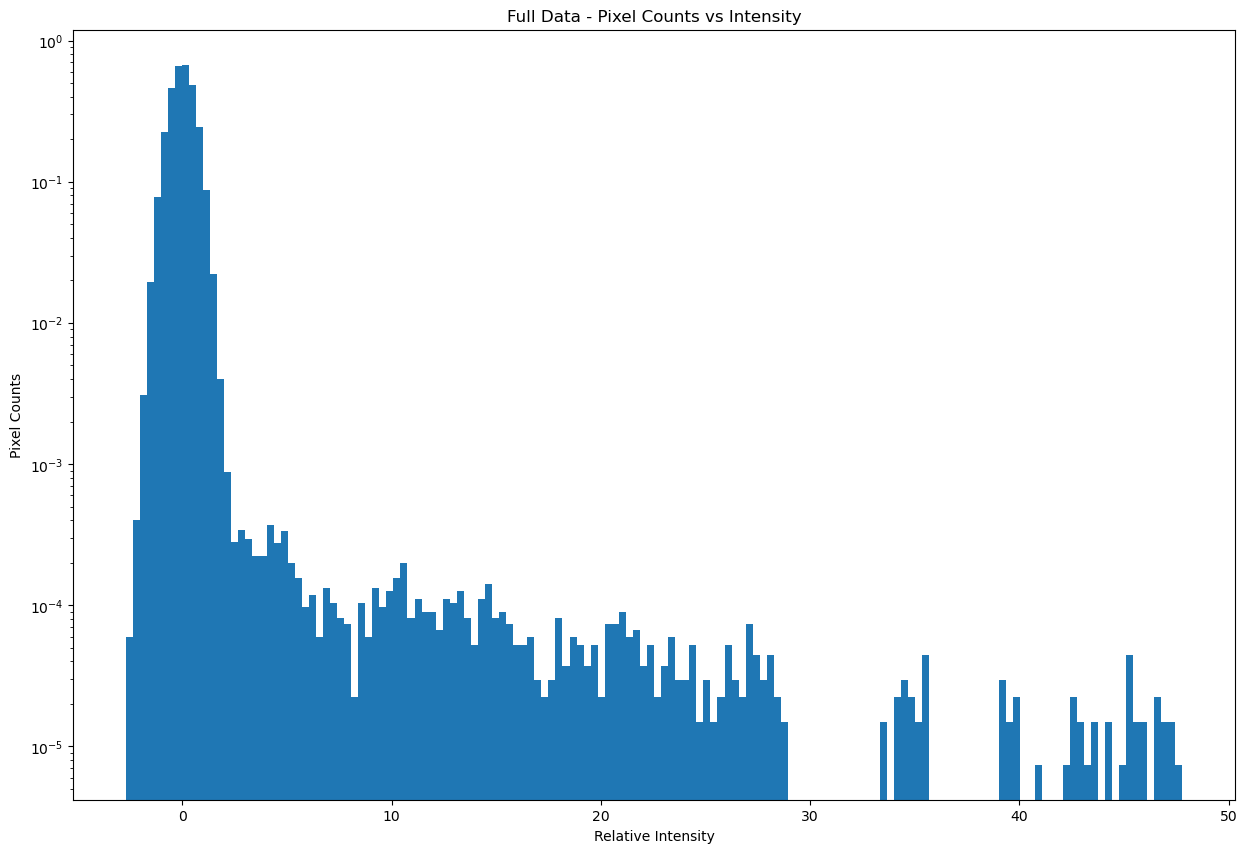

In [37]:
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(b,bins=150,density = True)
plt.yscale('log')
plt.ylabel('Pixel Counts')
plt.xlabel('Relative Intensity')
plt.title('Full Data - Pixel Counts vs Intensity');

From this I note 2 things:
1. The background distribution seems to be consistent with time. I can tell this because the gaussian centered at zero seems to have a consistent shape and peak.
2. There is no tail in the negative direction. This tells me that the tail in the positive direction is due to stars in the image, and the background is evenly distributed around zero.

Therefore, by taking the data from the range of 0 $\pm$ the minimum, I can plot the background distribution:

In [38]:
minimum = min(b)
minimum

-2.709336827866645

In [39]:
gaussian = []
for a in b:
    if minimum <= a <= -minimum:
        gaussian.append(a)

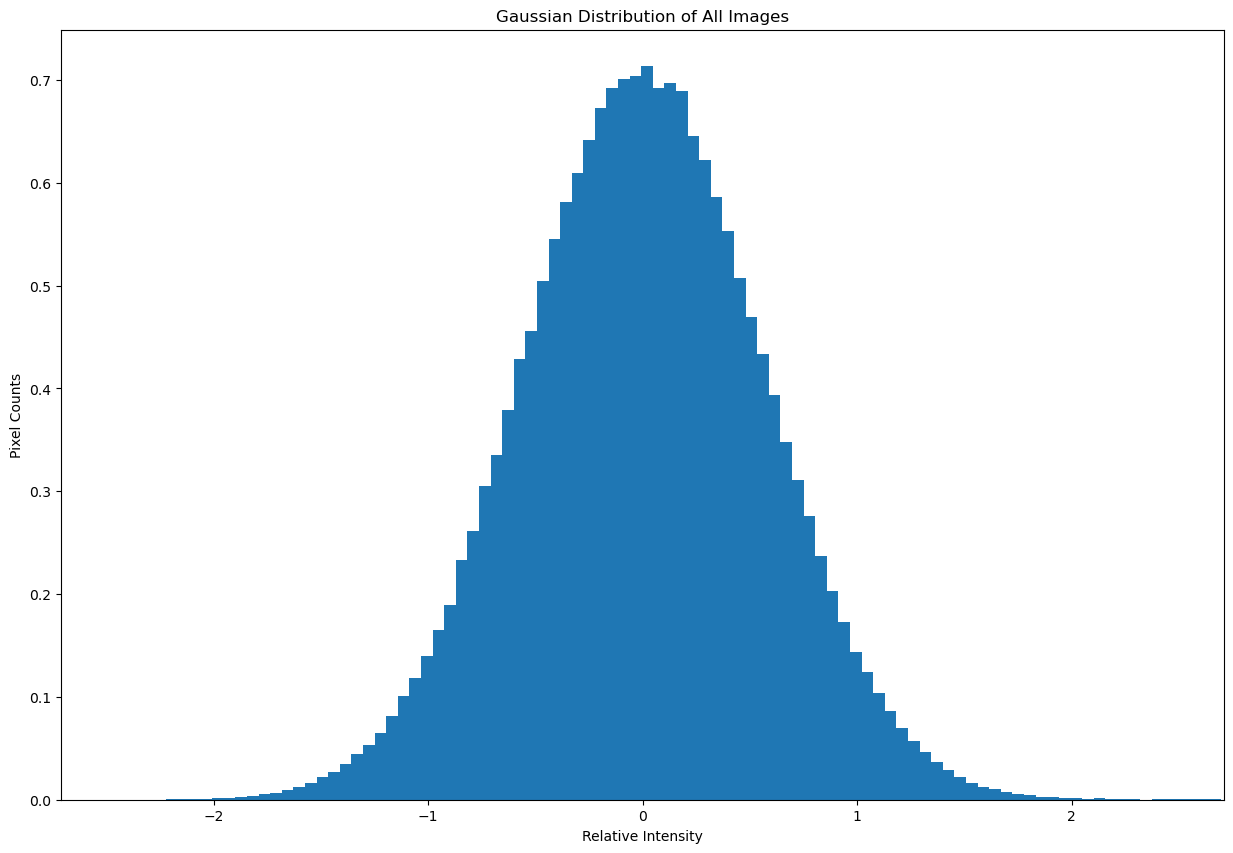

In [40]:
plt.hist(gaussian,bins=100,density = True)
plt.title('Gaussian Distribution of All Images')
plt.ylabel('Pixel Counts')
plt.xlabel('Relative Intensity')
plt.xlim(minimum,-minimum);

In [41]:
std = np.std(gaussian)

In [42]:
std

0.5624047644655374

In [43]:
x = np.linspace(minimum,-minimum+10,40000)
dist = stats.norm.pdf(x=x,loc=0,scale=std)

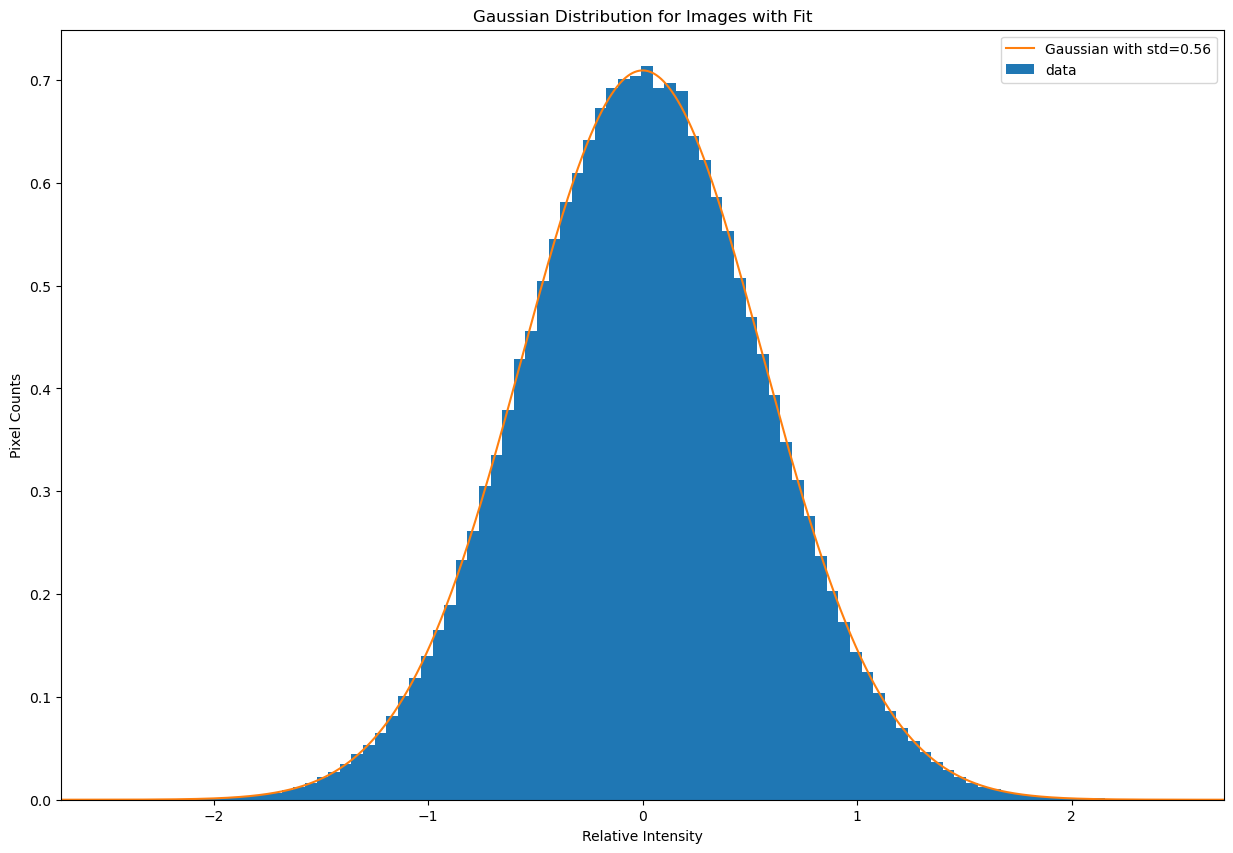

In [44]:
plt.hist(gaussian,bins=100,density=True, label='data')
plt.title('Gaussian Distribution for Images with Fit')
plt.ylabel('Pixel Counts')
plt.xlabel('Relative Intensity')
plt.xlim(minimum,-minimum)


plt.plot(x,dist,label='Gaussian with std=0.56')
plt.legend()

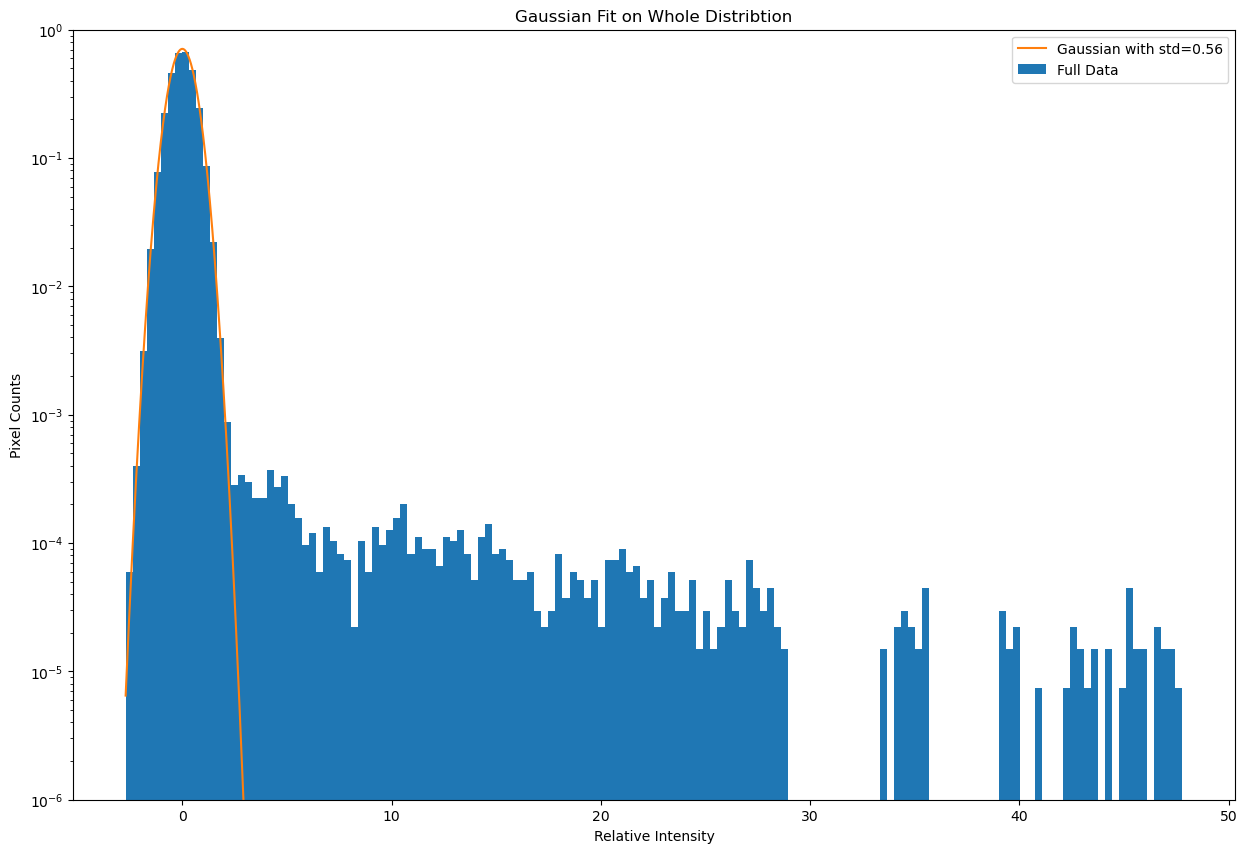

In [45]:
plt.hist(b,bins=150,density = True, label = 'Full Data')
plt.plot(x,dist, label='Gaussian with std=0.56')
plt.yscale('log')
plt.ylim(1e-6,1)
plt.title('Gaussian Fit on Whole Distribtion')
plt.ylabel('Pixel Counts')
plt.xlabel('Relative Intensity')
plt.legend();

# 3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.
Since we have 40,000 pixels in each image, and 10 images, to expect to see a pixel at an intensity would be 400,000 * probability = 1.

In [46]:
prob = 1/400000

intensity = stats.norm.ppf(1-prob,scale = std)

In [47]:
intensity

2.567258368283023

I will also state that "obvious" stars are stars above 5-sigma, which is:

In [48]:
prob = stats.norm.sf(5)
five_sigma = stats.norm.ppf(1 - prob/400000,scale=std)

In [49]:
five_sigma

3.982272848103425

So now I will look for stars between 2.5 and 3.89 intensity, which may be good candidates for faint stars.

In [50]:
def find_faint(img,lower=2.5,upper=3.89):
    faint_stars = np.where(img>lower,img,1000)
    faint_stars = np.where(faint_stars<upper,1,0)
    return faint_stars

In [51]:
faint_stars_array = []
for i in imgstack:
    faint_stars_array.append(find_faint(i))

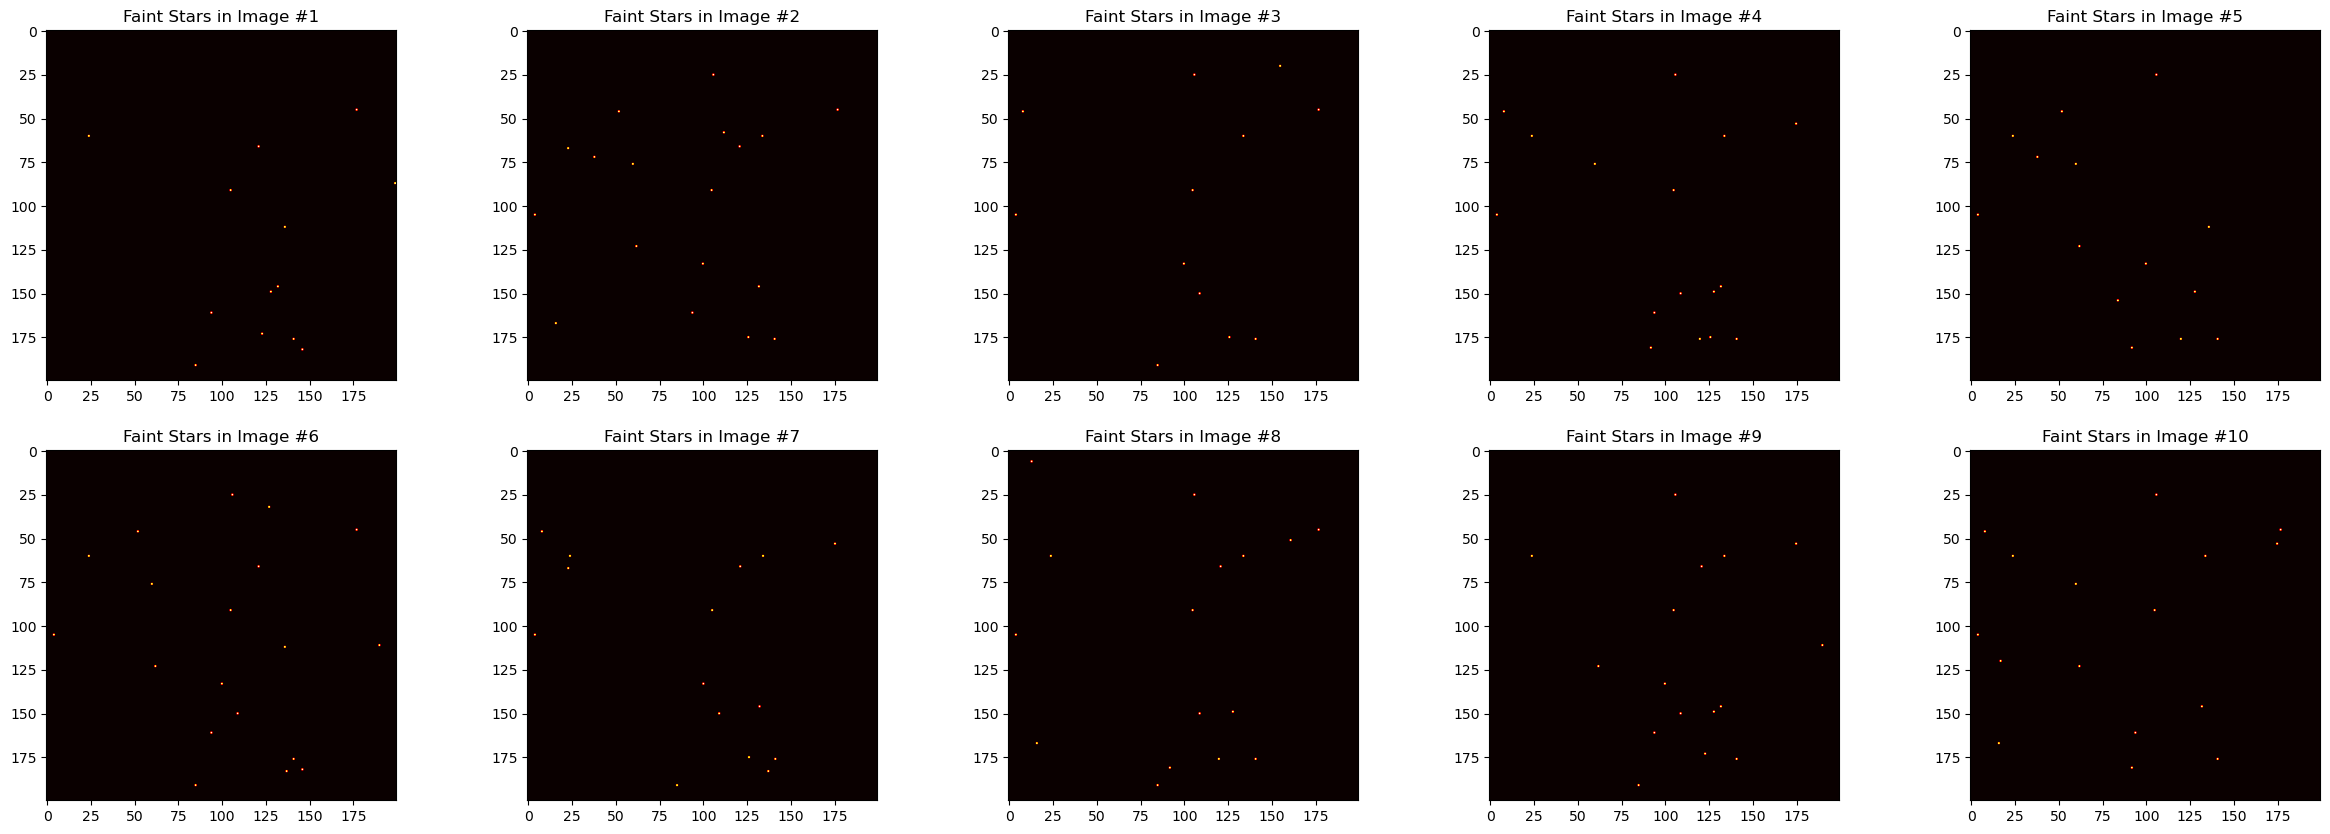

In [52]:
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(2, 5)
for i in range(2):
    for a in range(5):
        ax[i][a].imshow(faint_stars_array[a+(5*i)],cmap='hot')
        ax[i][a].set_title(f'Faint Stars in Image #{a+(5*i)+1}')

We can see that the faint stars from each image of the image stack are not exactly the same, but bear similarities. To reconcile this, by adding the images together, faint stars that have more than 1 occurance in that location will show up as brighter.

In [53]:
full_faints = np.zeros((200,200))
for i in faint_stars_array:
    full_faints += i

In [54]:
x = []
y = []
for a in range(len(full_faints[0])):
    for i in range(len(full_faints[1])):
          if full_faints[a][i] > 2:
                y.append(a)
                x.append(i)

Text(0.5, 1.0, 'Faint Stars -- Brighter = More Consistent')

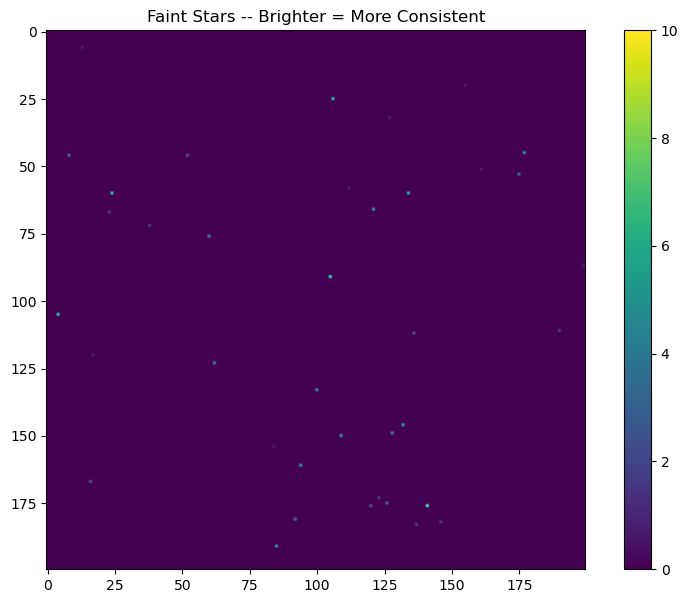

In [55]:
plt.rcParams["figure.figsize"] = (10,7)

plt.imshow(full_faints,cmap='viridis')
plt.colorbar()
plt.title('Faint Stars -- Brighter = More Consistent')
#plt.scatter(x,y,c='r',s=1)

---

Next, for visual clarity, I rescaled the brightness such that faint stars that were present 4 or more times got a value of 4, faint stars present 3 or less times got a value of 2, and anything that showed up only once or less got a value of 0. This makes it easy to tell where I have confirmed faint stars (a value of 4) and faint star candidates (a value of 2).

In [56]:
faints_rescale = np.where(full_faints>3,4,full_faints)
faints_rescale = np.where(faints_rescale<=1,10,faints_rescale)
faints_rescale = np.where(faints_rescale<4,2,faints_rescale)
faints_rescale = np.where(faints_rescale==10,0,faints_rescale)

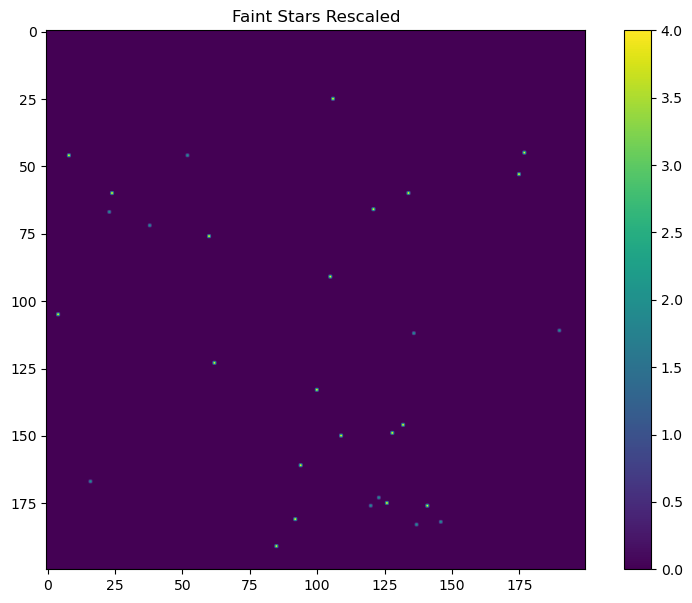

In [57]:
plt.imshow(faints_rescale,cmap='viridis')
plt.title('Faint Stars Rescaled')
plt.colorbar();

---

And finally plotting faint stars side-by-side with the bright stars and the full image:

In [58]:
#reusing my code to find faint stars in order to find all "bright" stars instead
full_stars = np.zeros((200,200))
for i in imgstack:
    full_stars += find_faint(i,lower=4,upper=50)

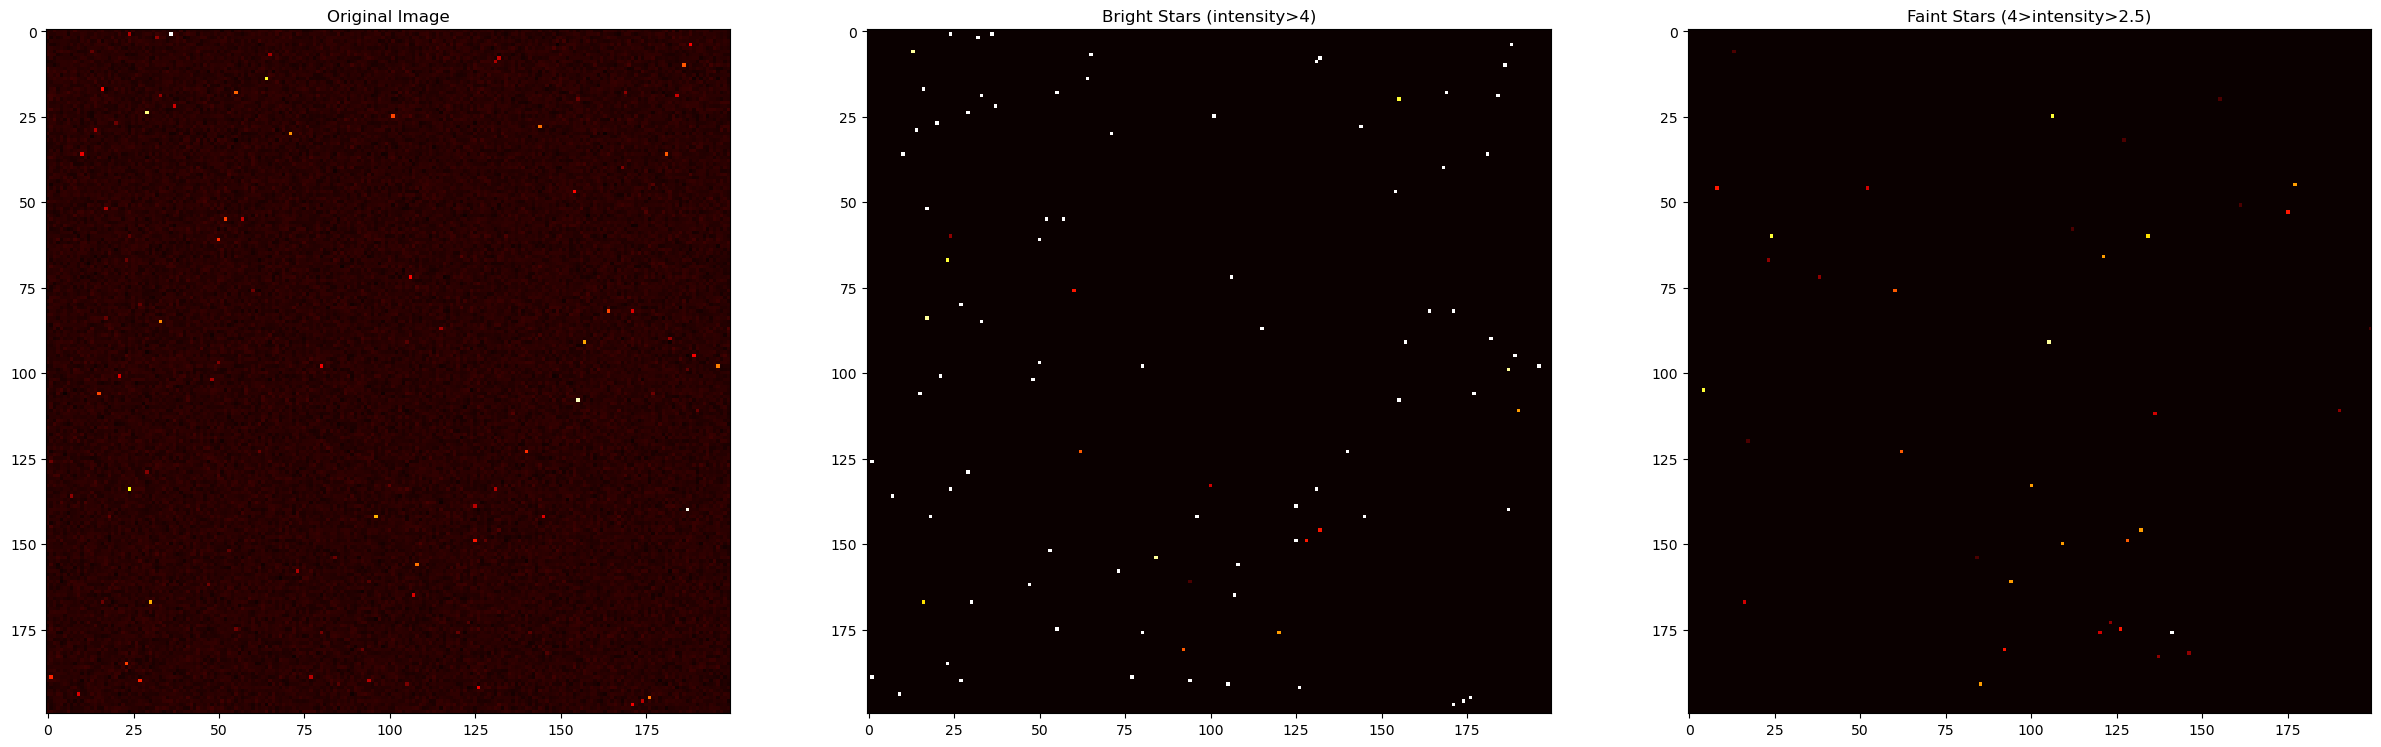

In [59]:
plt.rcParams["figure.figsize"] = (30,10)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(imgstack[0],cmap='hot')
ax[1].imshow(full_stars,cmap='hot')
ax[2].imshow(full_faints,cmap='hot')

ax[0].set_title('Original Image')
ax[1].set_title('Bright Stars (intensity>4)')
ax[2].set_title('Faint Stars (4>intensity>2.5)');

Some observations:

Right away it is clear that you could not identify the faint stars from the original image, but you could identify the bright stars -- I would consider this a success. There are some stars that probably border the intensity of 4, which is why there is some overlap (see x=100,y=25). Additionally, since I have removed the background, this is why the background of the bright/faint stars is black, while the original image is tinted red. 

# 4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.

I do believe we should both have the same distribution of background because the random noise in the images remains the same. However, the range of intensity we need to consider for our signal is different. This is because they are looking for transients, which may be bright but only show up in one image, while I am looking for stars that may be faint, but should show up in every image. So my lab partner probably considered all signals above 5-sigma, while I only considered those signals up to 5-sigma.